In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
from qutip import *

## Set the pulse

In [2]:
gamma = 1 
global_dt = 0.1 
minpointsperpulse = 5.0

def pulse_shape_gauss(t, args):
    width = args['width']
    norm = args['pulse_area']
    offset=args['t0']
    return norm/(2*width*np.sqrt(np.pi)) * np.exp(-((t - offset) / (2.0 * width))**2)

def pulse_shape(t, args):
    return  args['bg'] \
    + args['pulse_area']*(t>args['t0']-args['width'])*(t<args['t0']+args['width'])#

def pulse_train(t, args):
    args_1 = args.copy()
    args_1['t0'] = args_1['t0'] + args_1['pulse_dt']
    return pulse_shape(t, args) + pulse_shape(t, args_1)

def pulse_square_bg(t, args):
    width = args['width']
    norm = args['pulse_area']
    offset=args['t0']
    return args['bg'] + norm/(2*width*np.sqrt(np.pi))*(t>offset)*(t < offset + width)

def prepare_pulse(width, pulse_area=1, t0=3, tmin=0.0, tmax=100):
    pulseargs = {'width':width, 'tmin':tmin, 'tmax': tmax, 't0':t0} # define pulse properties
    pulseargs['pulse_area'] = pulse_area# * self.pulsenormconst(pulseargs)    # compute numerically the normalization constant
    pulseargs.update({"bg":0})
    tlist = np.linspace(tmin, tmax, int((tmax - tmin)/global_dt))                               # generate time list
    pulse = np.array([pulse_shape(t, pulseargs) for t in tlist])           # generate pulse shape
    return np.array(tlist), np.array(pulse), pulseargs

def evolve_delta_dt(pulse_args, emitter_args, delta, pulse_dt):
    upd_args = pulse_args.copy()
    upd_args['delta'] = delta; upd_args['pulse_dt'] = pulse_dt
    return evolve(upd_args, emitter_args)

def generate_imgs(pulse_args, emitter_args, evolve_delta_K, 
                            K_range, 
                            deltas_range=(-2, 2), 
                            delta_resolution = 100):
    deltas = np.linspace(deltas_range[0], deltas_range[1], delta_resolution)
    imgs = []
    for k in K_range:
        results = []
        for delta in deltas:
            tlist,_,result = evolve_delta_K(pulse_args,emitter_args,delta, k)
            results.append(result)
        img = np.zeros(len(tlist))
        for res in results:
            img = np.vstack((img, np.array(res.expect[0])))
        imgs.append(img.T)
    return imgs

## Set the evolution with two consequtive pulses

from types import SimpleNamespace
def evolve(pulse_args, emitter_args):
    pulse = SimpleNamespace(**pulse_args)
    emitter = SimpleNamespace(**emitter_args)
    g = fock(3,0)
    i = fock(3,1)
    e = fock(3,2)
    sm = e*g.dag()
    H0 = qeye(3)                       # identity because we are in the interaction picture
    H_0 = pulse.delta*sm*sm.dag()
    H_I = emitter.omega/2 * (sm + sm.dag()) # time dependent field
    
    H = [H_0, [H_I, pulse.pulse_func]]          # complete system Hamiltonian
    c_ops = [np.sqrt(emitter.gamma) * g*e.dag(), np.sqrt(emitter.gamma_2) * e*e.dag()]    # lowering operator for channel 1#, np.sqrt(gamma_2) * e*e.dag()
    e_ops = [e*e.dag(), g*g.dag(), sigmax(), sigmay(), sigmaz()] #\
    
    tlist, pulse_1, pulseargs = prepare_pulse(pulse.width, pulse.width * pulse.intensity *np.pi * (1/emitter.omega**2),pulse.t0
                                              , pulse.tmin, pulse.tmax)
    pulseargs.update({'pulse_dt':pulse.pulse_dt}) 
    pulseargs.update({'bg':pulse.bg})
    pulseargs_prepare = pulseargs.copy()
    pulseargs_prepare.update({'pulse_area': 0, 'tmax':50})
    #rho0 = mesolve(H, g, [0.0, 49.0], c_ops, None, args=pulseargs_prepare).states[-1]
    result = mesolve(H, g, tlist, c_ops, e_ops, args=pulseargs)
    return tlist, pulse_1, result

In [136]:
pulse_args = {'delta': 0, 
              'width': 0.5, 
              'intensity':40, 
              't0':5, 
              'pulse_dt':10,
              'wait_dt': 10,
              'tmin':0,
              'tmax':100,
              'bg':0.03,
             'pulse_func': pulse_square_bg}
emitter_args = {'omega': 4, 
                'gamma': 1/10, 
                'gamma_2':1/20,
               "gamma_red":10}

In [137]:
pulse = SimpleNamespace(**pulse_args)
emitter = SimpleNamespace(**emitter_args)
g = fock(3,0)
i = fock(3,1)
e = fock(3,2)
sm = e*g.dag()
H0 = qeye(3)                       # identity because we are in the interaction picture
H_0 = pulse.delta*sm*sm.dag()
H_I = emitter.omega/2 * (sm + sm.dag()) # time dependent field

H = [H_0, [H_I, pulse.pulse_func]]          # complete system Hamiltonian
c_ops = [np.sqrt(emitter.gamma_red) * g*i.dag(),
         np.sqrt(emitter.gamma) * i*e.dag() ,  np.sqrt(emitter.gamma) * g*e.dag(), np.sqrt(emitter.gamma_2) * e*e.dag()]
e_ops = [e*e.dag(), i*i.dag()] #\

tlist, pulse_1, pulseargs = prepare_pulse(pulse.width, 
                                          pulse.width * pulse.intensity *np.pi * (1/emitter.omega**2),
                                          pulse.t0, 
                                          pulse.tmin, 
                                          pulse.tmax)
pulseargs.update({'pulse_dt':pulse.pulse_dt}) 
pulseargs.update({'bg':pulse.bg})
pulseargs_prepare = pulseargs.copy()
pulseargs_prepare.update({'pulse_area': 0, 'tmax':50})
#rho0 = mesolve(H, g, [0.0, 49.0], c_ops, None, args=pulseargs_prepare).states[-1]
result = mesolve(H, (e + 2*g)/np.sqrt(2), tlist, c_ops, e_ops, args=pulseargs)

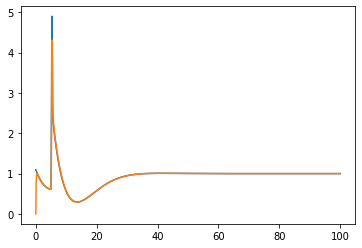

In [138]:
plt.plot(tlist, result.expect[0]/result.expect[0][-1])
plt.plot(tlist, result.expect[1]/result.expect[1][-1])

In [ ]:
tlist,_,result = evolve(pulse_args, emitter_args)

plt.plot(tlist, result.expect[0])

In [9]:
def evolve_delta_dt(pulse_args, emitter_args, delta, pulse_dt):
    upd_args = pulse_args.copy()
    upd_args['delta'] = delta;
    return evolve(upd_args, emitter_args)

In [444]:
imgs = generate_imgs(pulse_args, emitter_args, evolve_delta_dt, 
                               K_range=np.linspace(1, 25, 1), deltas_range=(-3,3))

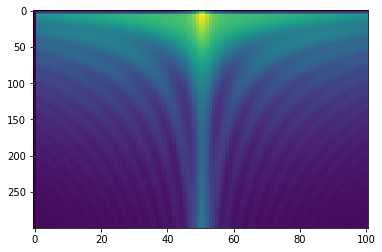

In [445]:
plt.imshow(imgs[0][:, :], aspect='auto')

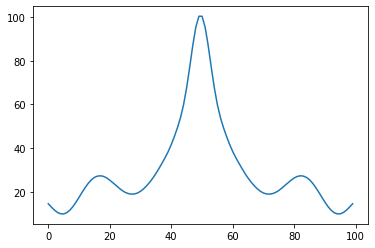

In [101]:
plt.plot(imgs[0][170:, 1:].sum(axis=0))

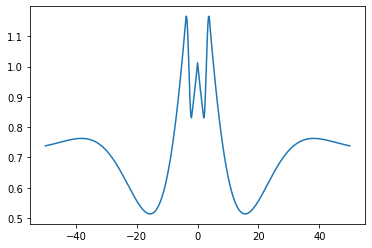

In [37]:
pop_eInf = mesolve(H_I, g, tlist, c_ops, [e*e.dag()]).expect[0][-1]
g2 = result.expect[0]/pop_eInf
g2_f = np.real(np.flip(g2))
g2 = np.concatenate((g2_f, g2))
tauS = np.concatenate((-np.flip(tlist), tlist))

plt.plot(tauS, g2)